136011.21 132545.43 129184.81 125940.02 122812.60 119810.53 116947.48 114218.75 111615.97 109141.49 106791.90 104564.18 102454.29 100463.32 98585.18 96812.23 95143.71 93577.61 92124.55 90771.55 89511.10 88342.86 87266.17 86276.78 85371.97 84546.10 83784.97 83084.43 82447.64 81857.34 81311.39 80808.71 80343.38 79916.13 79527.89 79176.55 78853.53 78556.67 78282.97 78030.03 77797.87 77580.90 77377.85 77188.73 77014.96 76853.26 76704.40 76569.90 76446.33 76331.23 76225.44 76127.24 76036.68 75951.90 75874.32 75804.21 75739.03 75677.63 75619.24 75565.21 75514.11 75466.48 75421.79 75379.88 75340.21 75302.92 75269.12 75237.94 75209.17 75181.67 75156.53 75132.71 75109.08 75088.22 75067.86 75048.55 75030.95 75014.28 74997.94 74982.56 74967.70 74953.26 74939.12 74925.77 74912.74 74900.98 74889.10 74878.13 74867.19 74857.09 74847.21 74837.84 74828.66 74819.49 74810.94 74803.13 74795.46 74787.96 74780.72 74773.40 
81973.44 78617.70 75467.58 72522.46 69806.12 67331.93 65099.78 63094.01 61310.08 5972

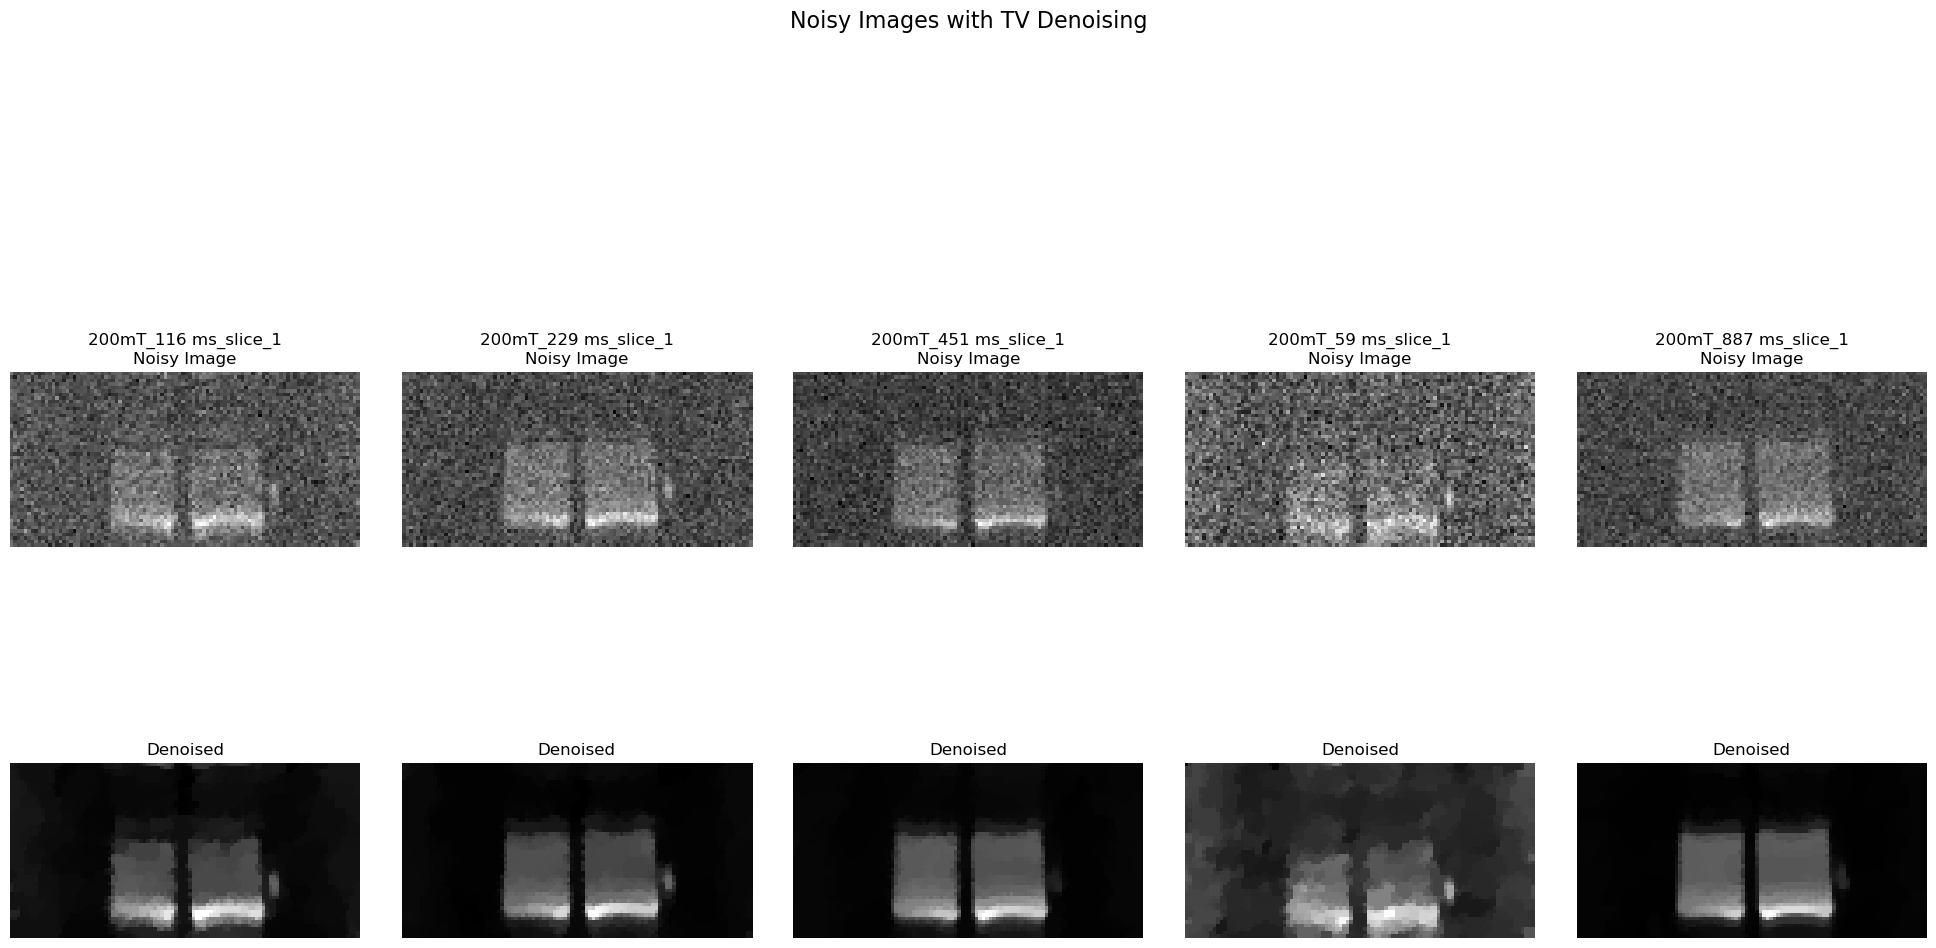

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from scipy.stats import entropy as scipy_entropy
from skimage.filters import laplace



    
def nabla(I):
    h, w = I.shape
    G = np.zeros((h, w, 2), I.dtype)
    G[:, :-1, 0] = I[:, 1:] - I[:, :-1]
    G[:-1, :, 1] = I[1:] - I[:-1]
    return G

def nablaT(G):
    h, w = G.shape[:2]
    I = np.zeros((h, w), G.dtype)
    I[:, :-1] -= G[:, :-1, 0]
    I[:, 1:] += G[:, :-1, 0]
    I[:-1] -= G[:-1, :, 1]
    I[1:] += G[:-1, :, 1]
    return I

def anorm(x):
    return np.sqrt((x**2).sum(-1))

def calc_energy_TVL1(X, observation, clambda):
    Ereg = anorm(nabla(X)).sum()
    Edata = clambda * np.abs(X - observation).sum()
    return Ereg + Edata
import numpy as np

def project_nd(P: np.ndarray, r: float) -> np.ndarray:
    '''
    Perform a pixel-wise projection onto R-radius balls.
    
    Parameters:
    P (np.ndarray): Input array.
    r (float): Radius of the projection.
    
    Returns:
    np.ndarray: Projected array.
    '''
    nP = np.maximum(1.0, anorm(P) / r)
    return P / nP[..., np.newaxis]
    
def shrink_1d(X: np.ndarray, F: np.ndarray, step: float) -> np.ndarray:
    '''
    Pixel-wise scalar shrinking.
    
    Parameters:
    X (np.ndarray): Input array.
    F (np.ndarray): Forward step array.
    step (float): Shrinkage step size.
    
    Returns:
    np.ndarray: Shrinked array.
    '''
    return X + np.clip(F - X, -step, step)


def solve_TVL1(img, clambda, iter_n=1000):
    L2 = 8.1
    tau = 0.025
    sigma = 1.0 / (L2 * tau)
    theta = 1.0
    X = img.copy()
    P = nabla(X)
    for i in range(iter_n):
        P = project_nd(P + sigma * nabla(X), 1.0)
        X1 = shrink_1d(X - tau * nablaT(P), img, clambda * tau)
        X = X1 + theta * (X1 - X)
        if i % 10 == 0:
            print("{:.2f}".format(calc_energy_TVL1(X, img, clambda)), end=' ')
    print()
    return X

lambda_TVL1 = 1

def load_tif_image(filepath):
    """Load a TIFF image as a numpy array."""
    with Image.open(filepath) as img:
        return np.array(img)

def process_tif_images(directory, clambda, iter_n=1000):
    files = os.listdir(directory)
    tif_files = [file for file in files if file.endswith('.tif')]
    tif_files.sort()

    num_images = len(tif_files)
    file_list = tif_files

    fig, axes = plt.subplots(2, num_images, figsize=(20, 12), facecolor='white')

    for i, file in enumerate(tif_files):
        img_path = os.path.join(directory, file)
        img = load_tif_image(img_path)
        filename = os.path.splitext(file)[0]
        if img.ndim == 3:
            img = np.mean(img, axis=2)  # Convert RGB to grayscale

        denoised_img = solve_TVL1(img, clambda, iter_n)
        noisy_img = img + np.random.normal(scale=25, size=img.shape)  # Adjust noise level as needed
        std_deviation = np.std(noisy_img)
       
        plt.subplot(2, num_images, i + 1)
        plt.imshow(noisy_img, cmap='gray')
        plt.title(f'{filename}\nNoisy Image')
        plt.axis('off')

        plt.subplot(2, num_images, i + num_images + 1)
        plt.imshow(denoised_img, cmap='gray')
        denoised_filename = f"denoised_{filename}.tiff"  # Create a unique filename outside imsave
        denoised_filepath = os.path.join(directory, denoised_filename)  # Construct full path
        plt.imsave(denoised_filepath, denoised_img, cmap='gray')
        plt.title(f'Denoised')
        plt.axis('off')

    # Set custom ticks for x-axis based on the number of images
    x_ticks_positions = np.linspace(0, 2 * (num_images - 1), num_images)
    x_tick_labels = [0, 2, 20] + [200] * (num_images - 3)
    plt.xticks(x_ticks_positions, x_tick_labels)

    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.85)
    plt.suptitle('Noisy Images with TV Denoising', fontsize=16, y=0.98)
    plt.show()

# Example usage:
directory = '../TraditionalMethods/Experiments/PhantomData/200mT'  # Update this path as necessary
process_tif_images(directory, clambda=lambda_TVL1)


99599.12 96176.57 92920.16 89829.43 86910.21 84158.33 81582.66 79177.90 76959.02 74922.95 73056.96 71360.40 69827.09 68446.96 67221.52 66131.98 65145.53 64255.34 63462.49 62763.12 62144.04 61593.96 61101.06 60666.07 60282.66 59944.17 59650.62 59391.86 59160.72 58957.94 58778.05 58612.72 58463.69 58329.98 58211.11 58105.49 58011.11 57927.21 57849.83 57779.86 57715.02 57653.95 57598.92 57547.68 57500.11 57455.33 57412.87 57373.51 57336.06 57300.75 57268.08 57237.70 57209.03 57181.93 57156.31 57132.05 57108.83 57086.92 57065.43 57044.73 57025.15 57006.73 56988.94 56971.83 56955.03 56939.62 56924.52 56910.19 56896.32 56882.79 56869.48 56856.73 56844.33 56832.35 56820.88 56809.75 56798.59 56787.59 56777.06 56767.13 56757.46 56747.92 56738.77 56729.51 56720.73 56711.98 56703.42 56695.76 56688.40 56681.65 56674.71 56668.00 56661.48 56654.84 56648.97 56643.58 56638.21 56633.47 56628.32 56623.63 
112689.90 109141.90 105724.07 102443.96 99304.94 96317.11 93485.38 90811.95 88304.23 85957.68 83761

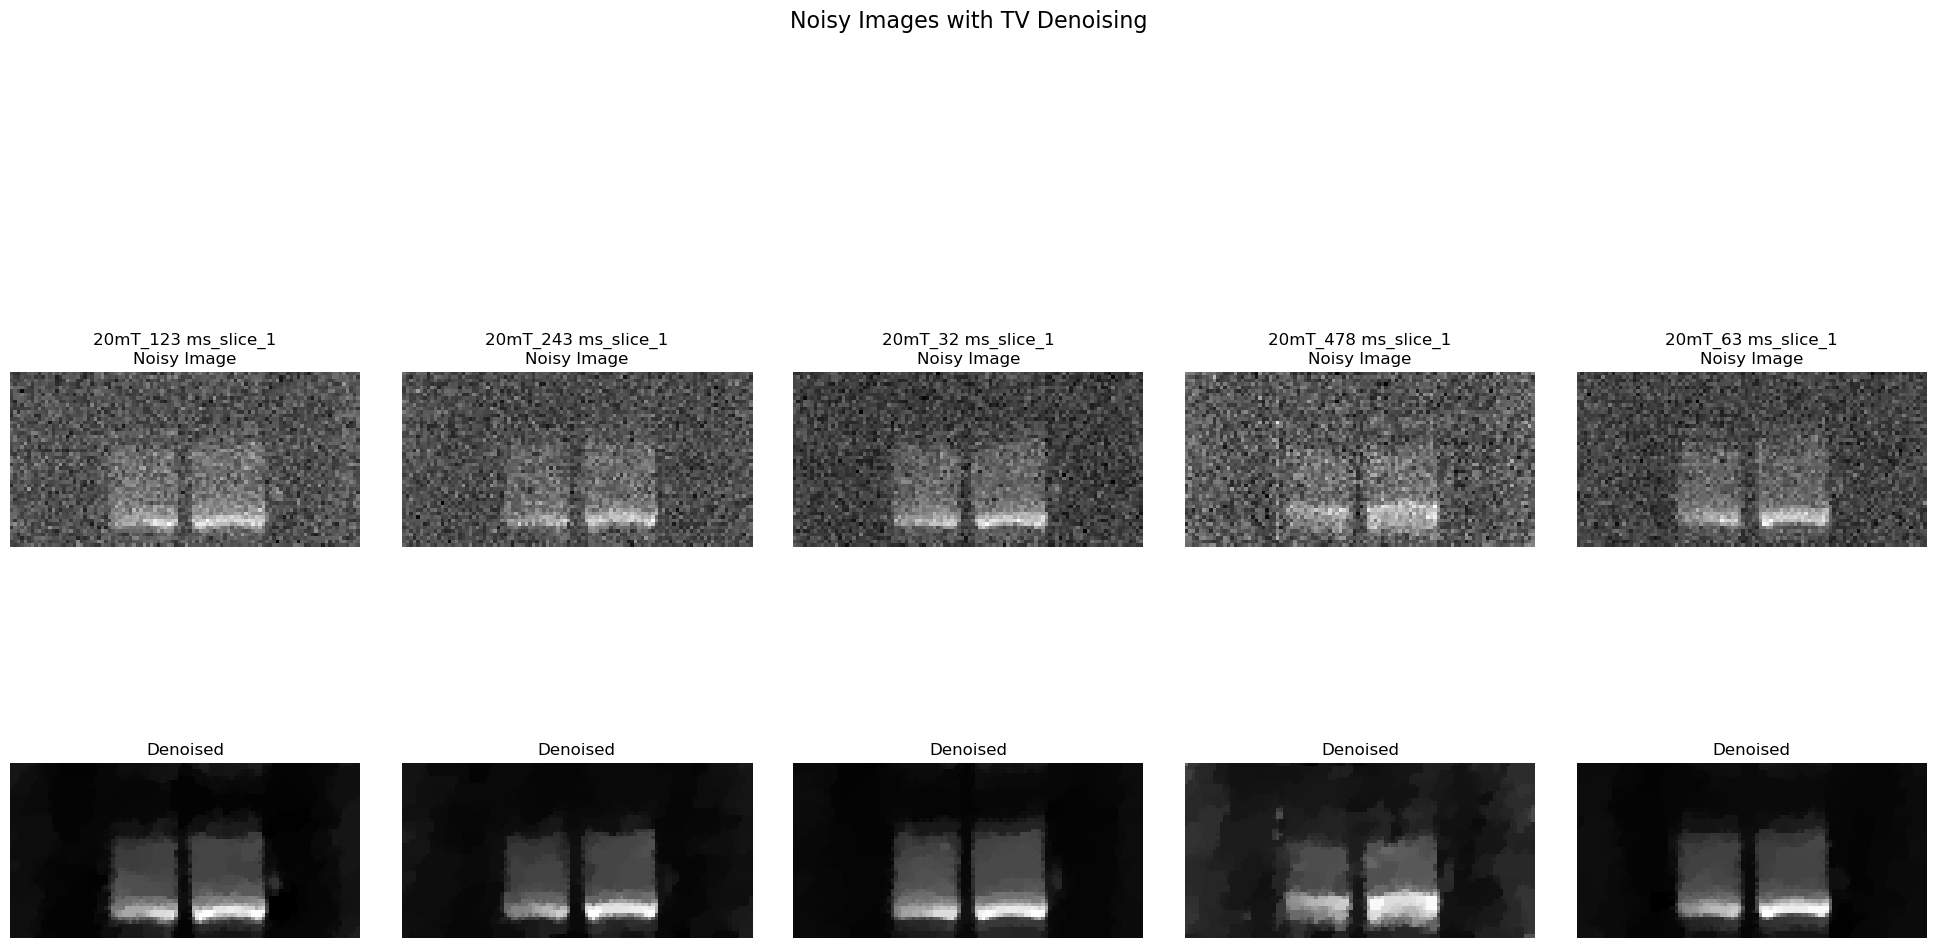

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from scipy.stats import entropy as scipy_entropy
from skimage.filters import laplace



    
def nabla(I):
    h, w = I.shape
    G = np.zeros((h, w, 2), I.dtype)
    G[:, :-1, 0] = I[:, 1:] - I[:, :-1]
    G[:-1, :, 1] = I[1:] - I[:-1]
    return G

def nablaT(G):
    h, w = G.shape[:2]
    I = np.zeros((h, w), G.dtype)
    I[:, :-1] -= G[:, :-1, 0]
    I[:, 1:] += G[:, :-1, 0]
    I[:-1] -= G[:-1, :, 1]
    I[1:] += G[:-1, :, 1]
    return I

def anorm(x):
    return np.sqrt((x**2).sum(-1))

def calc_energy_TVL1(X, observation, clambda):
    Ereg = anorm(nabla(X)).sum()
    Edata = clambda * np.abs(X - observation).sum()
    return Ereg + Edata
import numpy as np

def project_nd(P: np.ndarray, r: float) -> np.ndarray:
    '''
    Perform a pixel-wise projection onto R-radius balls.
    
    Parameters:
    P (np.ndarray): Input array.
    r (float): Radius of the projection.
    
    Returns:
    np.ndarray: Projected array.
    '''
    nP = np.maximum(1.0, anorm(P) / r)
    return P / nP[..., np.newaxis]
    
def shrink_1d(X: np.ndarray, F: np.ndarray, step: float) -> np.ndarray:
    '''
    Pixel-wise scalar shrinking.
    
    Parameters:
    X (np.ndarray): Input array.
    F (np.ndarray): Forward step array.
    step (float): Shrinkage step size.
    
    Returns:
    np.ndarray: Shrinked array.
    '''
    return X + np.clip(F - X, -step, step)


def solve_TVL1(img, clambda, iter_n=1000):
    L2 = 8.1
    tau = 0.025
    sigma = 1.0 / (L2 * tau)
    theta = 1.0
    X = img.copy()
    P = nabla(X)
    for i in range(iter_n):
        P = project_nd(P + sigma * nabla(X), 1.0)
        X1 = shrink_1d(X - tau * nablaT(P), img, clambda * tau)
        X = X1 + theta * (X1 - X)
        if i % 10 == 0:
            print("{:.2f}".format(calc_energy_TVL1(X, img, clambda)), end=' ')
    print()
    return X

lambda_TVL1 = 1

def load_tif_image(filepath):
    """Load a TIFF image as a numpy array."""
    with Image.open(filepath) as img:
        return np.array(img)

def process_tif_images(directory, clambda, iter_n=1000):
    files = os.listdir(directory)
    tif_files = [file for file in files if file.endswith('.tif')]
    tif_files.sort()

    num_images = len(tif_files)
    file_list = tif_files

    fig, axes = plt.subplots(2, num_images, figsize=(20, 12), facecolor='white')

    for i, file in enumerate(tif_files):
        img_path = os.path.join(directory, file)
        img = load_tif_image(img_path)
        filename = os.path.splitext(file)[0]
        if img.ndim == 3:
            img = np.mean(img, axis=2)  # Convert RGB to grayscale

        denoised_img = solve_TVL1(img, clambda, iter_n)
        noisy_img = img + np.random.normal(scale=25, size=img.shape)  # Adjust noise level as needed
        std_deviation = np.std(noisy_img)
       

        plt.subplot(2, num_images, i + 1)
        plt.imshow(noisy_img, cmap='gray')
        plt.title(f'{filename}\nNoisy Image')
        plt.axis('off')

        plt.subplot(2, num_images, i + num_images + 1)
        plt.imshow(denoised_img, cmap='gray')
        denoised_filename = f"denoised_{filename}.tiff"  # Create a unique filename outside imsave
        denoised_filepath = os.path.join(directory, denoised_filename)  # Construct full path
        plt.imsave(denoised_filepath, denoised_img, cmap='gray')
        plt.title(f'Denoised')
        plt.axis('off')

    # Set custom ticks for x-axis based on the number of images
    x_ticks_positions = np.linspace(0, 2 * (num_images - 1), num_images)
    x_tick_labels = [0, 2, 20] + [200] * (num_images - 3)
    plt.xticks(x_ticks_positions, x_tick_labels)

    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.85)
    plt.suptitle('Noisy Images with TV Denoising', fontsize=16, y=0.98)
    plt.show()

# Example usage:
directory = '../TraditionalMethods/Experiments/PhantomData/20mT'  # Update this path as necessary
process_tif_images(directory, clambda=lambda_TVL1)


158931.21 155245.78 151643.43 148126.46 144700.09 141376.76 138160.48 135051.66 132055.69 129172.76 126396.75 123735.53 121189.27 118759.87 116445.65 114246.78 112159.72 110173.38 108290.80 106518.39 104848.72 103281.88 101808.18 100418.41 99109.79 97880.96 96727.78 95657.89 94658.13 93731.51 92865.74 92056.88 91306.33 90607.18 89962.90 89363.12 88812.16 88302.84 87834.80 87405.79 87012.12 86646.46 86310.05 86000.26 85717.99 85460.09 85222.53 85008.13 84809.24 84625.91 84457.99 84302.80 84164.23 84038.60 83923.87 83819.30 83723.96 83636.61 83557.57 83482.88 83413.67 83350.34 83292.04 83238.39 83189.62 83144.00 83101.30 83061.66 83024.55 82990.11 82957.44 82927.59 82898.89 82871.18 82845.45 82820.55 82796.97 82774.12 82752.39 82732.31 82713.69 82696.56 82679.50 82663.26 82648.16 82633.52 82619.03 82605.78 82592.49 82580.03 82567.61 82555.95 82545.24 82534.67 82524.84 82515.04 82506.11 82497.03 82489.11 82481.38 
81825.57 78482.73 75339.71 72420.10 69736.72 67290.79 65094.29 63131.06 613

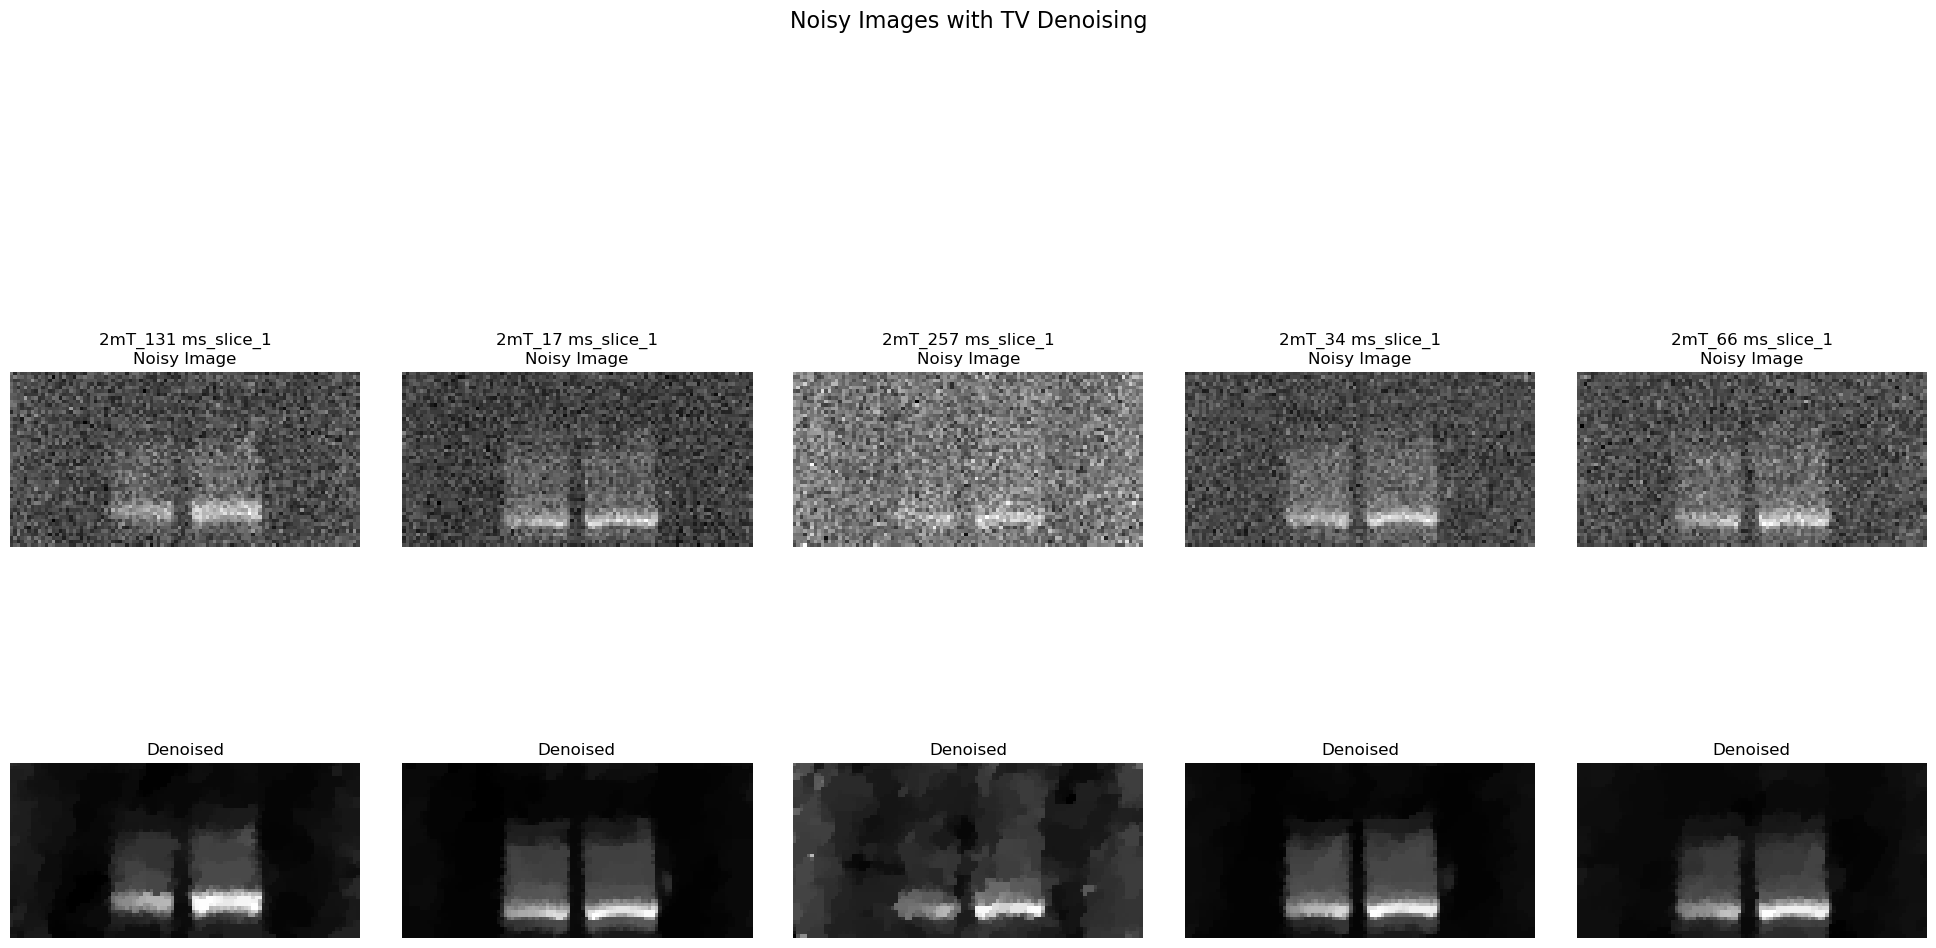

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from scipy.stats import entropy as scipy_entropy
from skimage.filters import laplace



def nabla(I):
    h, w = I.shape
    G = np.zeros((h, w, 2), I.dtype)
    G[:, :-1, 0] = I[:, 1:] - I[:, :-1]
    G[:-1, :, 1] = I[1:] - I[:-1]
    return G

def nablaT(G):
    h, w = G.shape[:2]
    I = np.zeros((h, w), G.dtype)
    I[:, :-1] -= G[:, :-1, 0]
    I[:, 1:] += G[:, :-1, 0]
    I[:-1] -= G[:-1, :, 1]
    I[1:] += G[:-1, :, 1]
    return I

def anorm(x):
    return np.sqrt((x**2).sum(-1))

def calc_energy_TVL1(X, observation, clambda):
    Ereg = anorm(nabla(X)).sum()
    Edata = clambda * np.abs(X - observation).sum()
    return Ereg + Edata
import numpy as np

def project_nd(P: np.ndarray, r: float) -> np.ndarray:
    '''
    Perform a pixel-wise projection onto R-radius balls.
    
    Parameters:
    P (np.ndarray): Input array.
    r (float): Radius of the projection.
    
    Returns:
    np.ndarray: Projected array.
    '''
    nP = np.maximum(1.0, anorm(P) / r)
    return P / nP[..., np.newaxis]
    
def shrink_1d(X: np.ndarray, F: np.ndarray, step: float) -> np.ndarray:
    '''
    Pixel-wise scalar shrinking.
    
    Parameters:
    X (np.ndarray): Input array.
    F (np.ndarray): Forward step array.
    step (float): Shrinkage step size.
    
    Returns:
    np.ndarray: Shrinked array.
    '''
    return X + np.clip(F - X, -step, step)


def solve_TVL1(img, clambda, iter_n=1000):
    L2 = 8.1
    tau = 0.025
    sigma = 1.0 / (L2 * tau)
    theta = 1.0
    X = img.copy()
    P = nabla(X)
    for i in range(iter_n):
        P = project_nd(P + sigma * nabla(X), 1.0)
        X1 = shrink_1d(X - tau * nablaT(P), img, clambda * tau)
        X = X1 + theta * (X1 - X)
        if i % 10 == 0:
            print("{:.2f}".format(calc_energy_TVL1(X, img, clambda)), end=' ')
    print()
    return X

lambda_TVL1 = 1

def load_tif_image(filepath):
    """Load a TIFF image as a numpy array."""
    with Image.open(filepath) as img:
        return np.array(img)

def process_tif_images(directory, clambda, iter_n=1000):
    files = os.listdir(directory)
    tif_files = [file for file in files if file.endswith('.tif')]
    tif_files.sort()

    num_images = len(tif_files)
    file_list = tif_files

    fig, axes = plt.subplots(2, num_images, figsize=(20, 12), facecolor='white')

    for i, file in enumerate(tif_files):
        img_path = os.path.join(directory, file)
        img = load_tif_image(img_path)
        filename = os.path.splitext(file)[0]
        if img.ndim == 3:
            img = np.mean(img, axis=2)  # Convert RGB to grayscale

        denoised_img = solve_TVL1(img, clambda, iter_n)
        noisy_img = img + np.random.normal(scale=25, size=img.shape)  # Adjust noise level as needed
        std_deviation = np.std(noisy_img)
      
        plt.subplot(2, num_images, i + 1)
        plt.imshow(noisy_img, cmap='gray')
        plt.title(f'{filename}\nNoisy Image')
        plt.axis('off')

        plt.subplot(2, num_images, i + num_images + 1)
        plt.imshow(denoised_img, cmap='gray')
        denoised_filename = f"denoised_{filename}.tiff"  # Create a unique filename outside imsave
        denoised_filepath = os.path.join(directory, denoised_filename)  # Construct full path
        plt.imsave(denoised_filepath, denoised_img, cmap='gray')
        plt.title(f'Denoised')
        plt.axis('off')

    # Set custom ticks for x-axis based on the number of images
    x_ticks_positions = np.linspace(0, 2 * (num_images - 1), num_images)
    x_tick_labels = [0, 2, 20] + [200] * (num_images - 3)
    plt.xticks(x_ticks_positions, x_tick_labels)

    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.85)
    plt.suptitle('Noisy Images with TV Denoising', fontsize=16, y=0.98)
    plt.show()

# Example usage:
directory = '../TraditionalMethods/Experiments/PhantomData/2mT'  # Update this path as necessary
process_tif_images(directory, clambda=lambda_TVL1)

299758.01 295885.78 292056.63 288268.99 284527.96 280830.30 277178.05 273575.66 270026.60 266532.02 263097.47 259721.91 256406.49 253147.91 249946.69 246804.30 243718.58 240694.77 237731.11 234828.45 231988.35 229212.32 226497.86 223841.71 221245.49 218707.79 216225.23 213796.03 211420.15 209100.96 206834.18 204625.32 202474.40 200375.36 198329.32 196337.37 194398.83 192512.27 190680.22 188901.75 187176.58 185497.46 183869.77 182291.42 180765.90 179297.53 177878.79 176507.97 175184.62 173909.86 172685.57 171504.40 170370.80 169272.80 168217.79 167202.04 166222.74 165283.73 164375.36 163500.35 162656.02 161842.03 161060.01 160301.34 159569.81 158864.89 158188.19 157535.69 156905.71 156299.49 155715.29 155150.52 154609.08 154088.04 153586.37 153102.54 152636.45 152189.38 151759.11 151347.28 150951.99 150572.70 150209.27 149857.99 149520.50 149194.91 148881.80 148582.54 148294.22 148018.09 147754.98 147502.97 147259.04 147025.56 146801.33 146586.72 146381.44 146185.46 145995.96 145815.36 

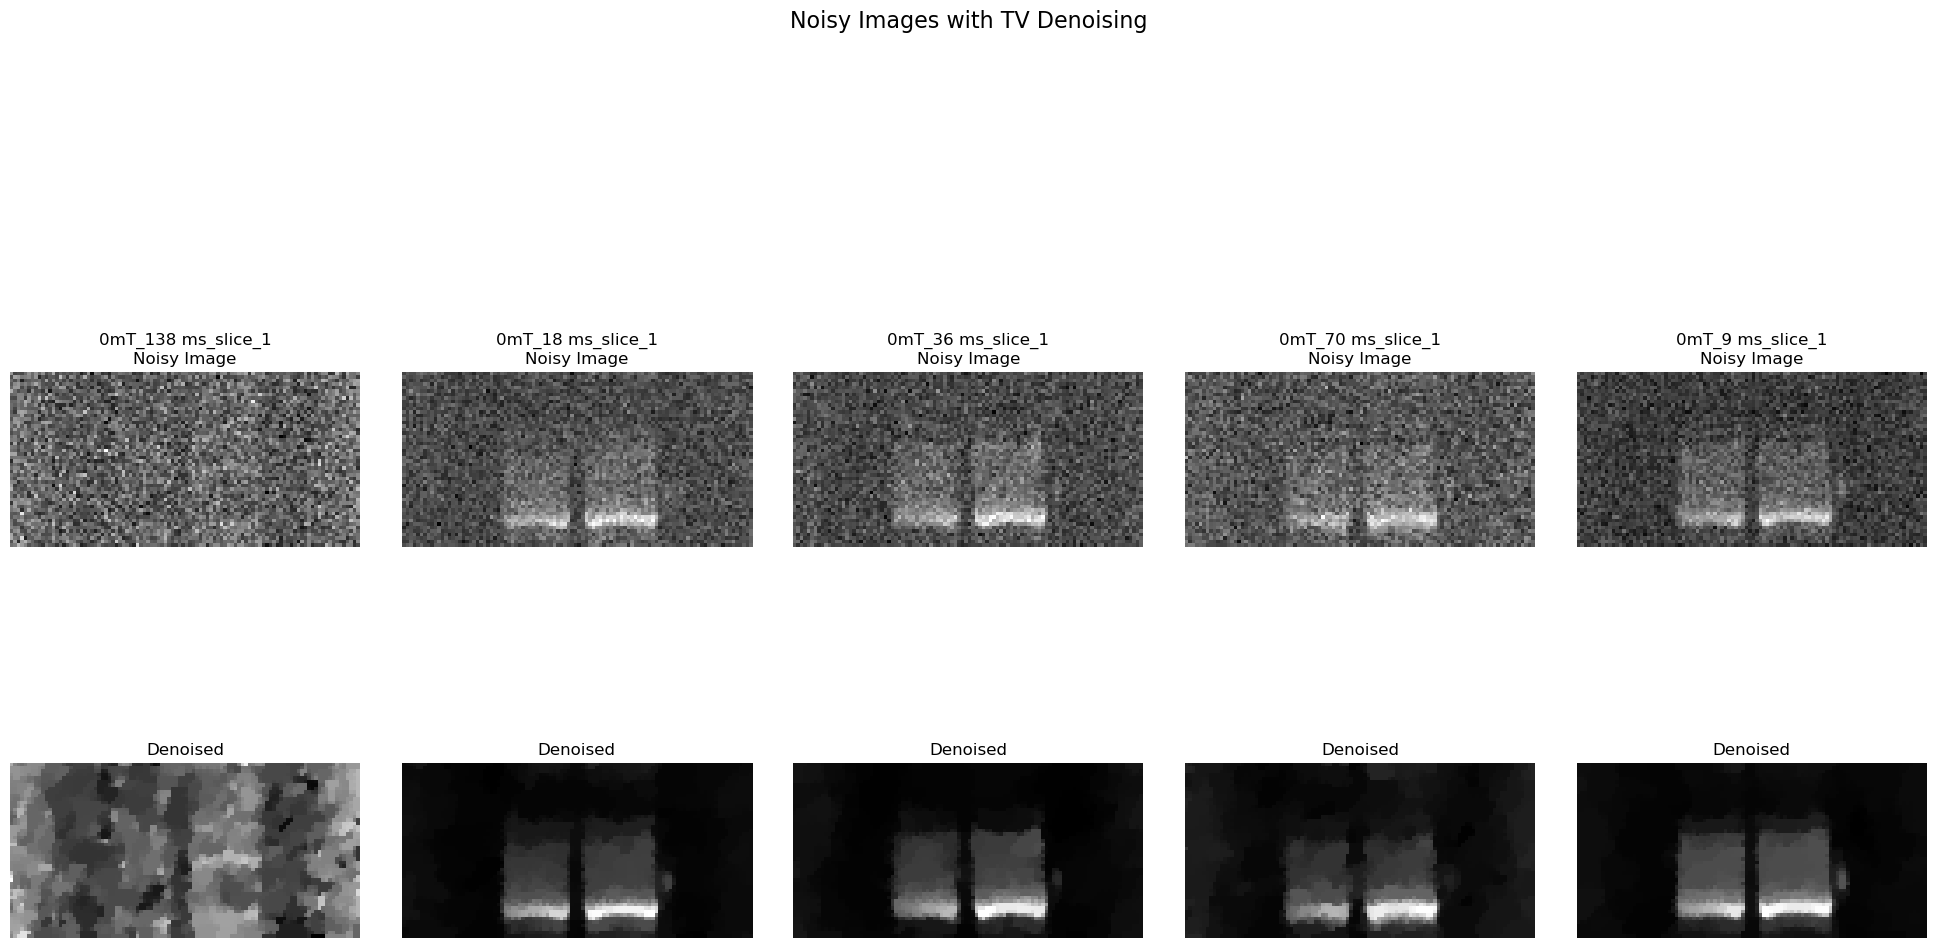

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from scipy.stats import entropy as scipy_entropy
from skimage.filters import laplace



    
def nabla(I):
    h, w = I.shape
    G = np.zeros((h, w, 2), I.dtype)
    G[:, :-1, 0] = I[:, 1:] - I[:, :-1]
    G[:-1, :, 1] = I[1:] - I[:-1]
    return G

def nablaT(G):
    h, w = G.shape[:2]
    I = np.zeros((h, w), G.dtype)
    I[:, :-1] -= G[:, :-1, 0]
    I[:, 1:] += G[:, :-1, 0]
    I[:-1] -= G[:-1, :, 1]
    I[1:] += G[:-1, :, 1]
    return I

def anorm(x):
    return np.sqrt((x**2).sum(-1))

def calc_energy_TVL1(X, observation, clambda):
    Ereg = anorm(nabla(X)).sum()
    Edata = clambda * np.abs(X - observation).sum()
    return Ereg + Edata
import numpy as np

def project_nd(P: np.ndarray, r: float) -> np.ndarray:
    '''
    Perform a pixel-wise projection onto R-radius balls.
    
    Parameters:
    P (np.ndarray): Input array.
    r (float): Radius of the projection.
    
    Returns:
    np.ndarray: Projected array.
    '''
    nP = np.maximum(1.0, anorm(P) / r)
    return P / nP[..., np.newaxis]
    
def shrink_1d(X: np.ndarray, F: np.ndarray, step: float) -> np.ndarray:
    '''
    Pixel-wise scalar shrinking.
    
    Parameters:
    X (np.ndarray): Input array.
    F (np.ndarray): Forward step array.
    step (float): Shrinkage step size.
    
    Returns:
    np.ndarray: Shrinked array.
    '''
    return X + np.clip(F - X, -step, step)


def solve_TVL1(img, clambda, iter_n=1000):
    L2 = 8.1
    tau = 0.025
    sigma = 1.0 / (L2 * tau)
    theta = 1.0
    X = img.copy()
    P = nabla(X)
    for i in range(iter_n):
        P = project_nd(P + sigma * nabla(X), 1.0)
        X1 = shrink_1d(X - tau * nablaT(P), img, clambda * tau)
        X = X1 + theta * (X1 - X)
        if i % 10 == 0:
            print("{:.2f}".format(calc_energy_TVL1(X, img, clambda)), end=' ')
    print()
    return X

lambda_TVL1 = 1

def load_tif_image(filepath):
    """Load a TIFF image as a numpy array."""
    with Image.open(filepath) as img:
        return np.array(img)

def process_tif_images(directory, clambda, iter_n=1000):
    files = os.listdir(directory)
    tif_files = [file for file in files if file.endswith('.tif')]
    tif_files.sort()

    num_images = len(tif_files)
    file_list = tif_files

    fig, axes = plt.subplots(2, num_images, figsize=(20, 12), facecolor='white')

    for i, file in enumerate(tif_files):
        img_path = os.path.join(directory, file)
        img = load_tif_image(img_path)
        filename = os.path.splitext(file)[0]
        if img.ndim == 3:
            img = np.mean(img, axis=2)  # Convert RGB to grayscale

        denoised_img = solve_TVL1(img, clambda, iter_n)
        noisy_img = img + np.random.normal(scale=25, size=img.shape)  # Adjust noise level as needed
        std_deviation = np.std(noisy_img)


        plt.subplot(2, num_images, i + 1)
        plt.imshow(noisy_img, cmap='gray')
        plt.title(f'{filename}\nNoisy Image')
        plt.axis('off')

        plt.subplot(2, num_images, i + num_images + 1)
        plt.imshow(denoised_img, cmap='gray')
        denoised_filename = f"denoised_{filename}.tiff"  # Create a unique filename outside imsave
        denoised_filepath = os.path.join(directory, denoised_filename)  # Construct full path
        plt.imsave(denoised_filepath, denoised_img, cmap='gray')
        plt.title(f'Denoised')
        plt.axis('off')

    # Set custom ticks for x-axis based on the number of images
    x_ticks_positions = np.linspace(0, 2 * (num_images - 1), num_images)
    x_tick_labels = [0, 2, 20] + [200] * (num_images - 3)
    plt.xticks(x_ticks_positions, x_tick_labels)

    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.85)
    plt.suptitle('Noisy Images with TV Denoising', fontsize=16, y=0.98)
    plt.show()

# Example usage:
directory = '../TraditionalMethods/Experiments/PhantomData/OmT'  # Update this path as necessary
process_tif_images(directory, clambda=lambda_TVL1)

NameError: name 'signal_region' is not defined

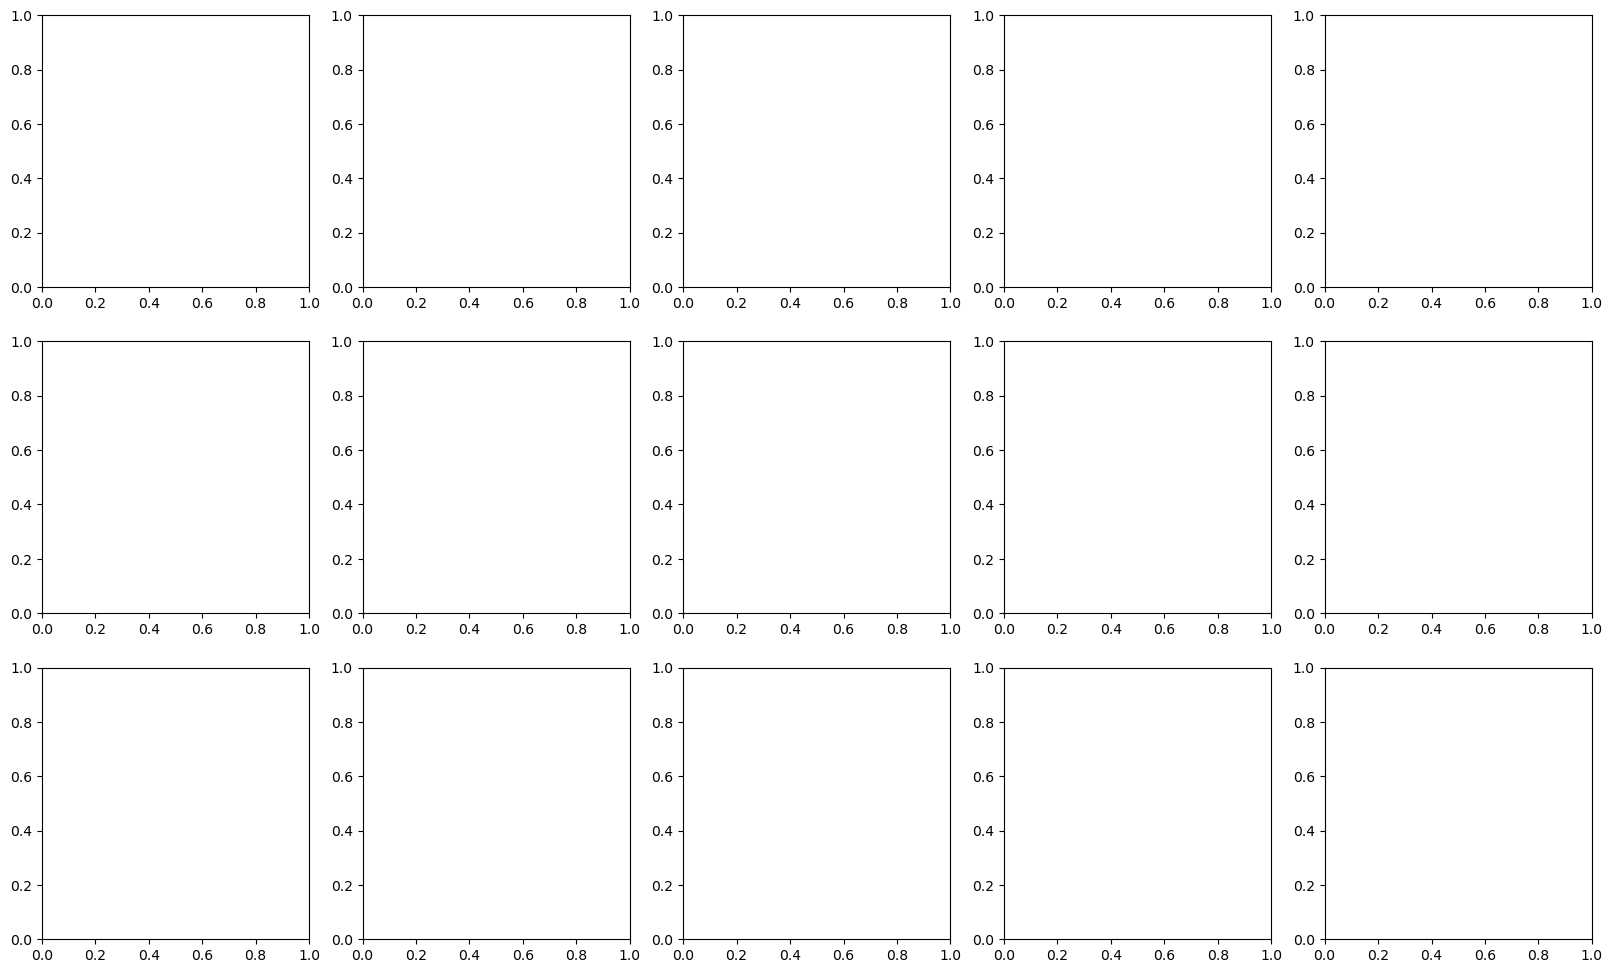

In [5]:
def extract_left_roi(image, width_percent=50):
    """
    Extract the left side region of interest (ROI) from the image.

    Args:
        image (np.ndarray): The input image.
        width_percent (int): The width percentage of the image to consider for ROI.

    Returns:
        np.ndarray: The ROI of the image.
    """
    roi_width = image.shape[1] * width_percent // 100
    return image[:, :roi_width] 



 
def calculate_snr(signal, noise):
    # Your SNR calculation code
    mean_signal = np.mean(signal_region)
    std_noise = np.std(signal_region)
    snr = mean_signal / std_noise if std_noise > 0 else 0
    return snr

def calculate_cnr(signal_region, background_region):
    """
    Calculate the Contrast-to-Noise Ratio (CNR).

    Args:
        signal_region (np.ndarray): The region of the image considered as the signal.
        background_region (np.ndarray): The region of the image considered as the background.

    Returns:
        float: The CNR value.
    """
    mean_signal = np.mean(signal_region)
    mean_background = np.mean(background_region)
    std_background = np.std(background_region)
    cnr = (mean_signal - mean_background) / std_background if std_background > 0 else 0
    return cnr



# Update your process_tif_images function to include ROI extraction and SNR/CNR calculations
def process_tif_images(directory, clambda, iter_n=1000):
    files = os.listdir(directory)
    tif_files = [file for file in files if file.endswith('.tif')]
    tif_files.sort()

    num_images = len(tif_files)

    fig, axes = plt.subplots(3, num_images, figsize=(20, 12), facecolor='white')  # Update for 3 rows

    for i, file in enumerate(tif_files):
        img_path = os.path.join(directory, file)
        img = load_tif_image(img_path)
        filename = os.path.splitext(file)[0]
        if img.ndim == 3:
            img = np.mean(img, axis=2)  # Convert RGB to grayscale

        # Assume the left half of the image is the ROI
        roi = extract_left_roi(img)

        # Additional variables for ROI-based SNR and CNR calculations
        signal_region = ...  # Define how to get the signal region from the ROI
        background_region = ...  # Define how to get the background region from the ROI

        snr_value = calculate_snr(signal_region, background_region)
        cnr_value = calculate_cnr(signal_region, background_region)

        denoised_img = solve_TVL1(roi, clambda, iter_n)  # Apply denoising to ROI
        noisy_img = roi + np.random.normal(scale=25, size=roi.shape)  # Add noise to ROI

        # Display the noisy ROI
        plt.subplot(3, num_images, i + 1)
        plt.imshow(noisy_img, cmap='gray')
        plt.title(f'{filename}\nNoisy ROI')
        plt.axis('off')

        # Display the denoised ROI
        plt.subplot(3, num_images, i + num_images + 1)
        plt.imshow(denoised_img, cmap='gray')
        plt.title(f'Denoised ROI')
        plt.axis('off')

        # Display SNR and CNR values
        plt.subplot(3, num_images, i + 2*num_images + 1)
        plt.text(0.5, 0.5, f'SNR: {snr_value:.2f}\nCNR: {cnr_value:.2f}', horizontalalignment='center', verticalalignment='center')
        plt.axis('off')

    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.85)
    plt.suptitle('Analysis of Left Side ROI in Images', fontsize=16, y=0.98)
    plt.show()

# Example usage
process_tif_images(directory, clambda=lambda_TVL1)


